IMPORTATION DES BIBLIOTHEQUES

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay,
    roc_auc_score,
    classification_report,
)

# XGBoost (installer si besoin)
try:
    from xgboost import XGBClassifier
except Exception:
    !pip -q install xgboost
    from xgboost import XGBClassifier

In [3]:
from google.colab import files
uploaded = files.upload()  # upload WA_Fn-UseC_-Telco-Customer-Churn.xls

df = pd.read_excel("WA_Fn-UseC_-Telco-Customer-Churn.xls")
print(df.shape)
df.head()

Saving WA_Fn-UseC_-Telco-Customer-Churn.xls to WA_Fn-UseC_-Telco-Customer-Churn.xls
(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


NETTOYAGE DES DONNES ET PREPARATION DE LA VARIABLE CIBLE

In [4]:
# 1) Uniformiser les noms de colonnes
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

# 2) Supprimer l'identifiant (inutile pour ML)
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

# 3) Nettoyer les chaînes : espaces, vides -> NaN
obj_cols = df.select_dtypes(include="object").columns
df[obj_cols] = df[obj_cols].apply(lambda s: s.astype(str).str.strip())
df = df.replace(r"^\s*$", np.nan, regex=True)

# 4) Convertir TotalCharges (souvent stockée en texte)
# (dans Telco, il peut y avoir des ' ' / vides si tenure=0)
if "TotalCharges" in df.columns:
    df["TotalCharges"] = df["TotalCharges"].astype(str).str.replace(",", ".", regex=False)
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# 5) variable Cible "Churn ": Yes/No -> 1/0
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

print("Valeurs manquantes par colonne (top 10):")
display(df.isna().sum().sort_values(ascending=False).head(10))

df.head()

Valeurs manquantes par colonne (top 10):


,0
TotalCharges,11
gender,0
Partner,0
SeniorCitizen,0
Dependents,0
tenure,0
MultipleLines,0
PhoneService,0
OnlineSecurity,0
OnlineBackup,0


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


TRAIN/TEST SPLIT

In [5]:
X = df.drop(columns=["Churn"])
y = df["Churn"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)
print("Proportion churn=1 (train):", y_train.mean())

(5634, 19) (1409, 19)
Proportion churn=1 (train): 0.2653532126375577


PREPROCESSING DE LA DATA: IMPUTATION ,ENCODAGE ET NORMALISATION

In [6]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

# Fit uniquement sur train (important)
preprocessor.fit(X_train)

X_train_enc = preprocessor.transform(X_train)
X_test_enc  = preprocessor.transform(X_test)

print("Train encodé shape:", X_train_enc.shape)
print("Test encodé shape :", X_test_enc.shape)

Train encodé shape: (5634, 45)
Test encodé shape : (1409, 45)


In [7]:
def evaluate_best_model(name, grid, X_train, y_train, X_test, y_test):
    print("="*80)
    print(f"MODELE : {name}")

    # Validation croisée + recherche hyperparamètres
    grid.fit(X_train, y_train)

    print("Meilleurs paramètres :", grid.best_params_)
    print(f"Meilleur score CV (ROC-AUC) : {grid.best_score_:.4f}")

    best_model = grid.best_estimator_

    # Prédictions test
    y_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    # AUC test
    auc_test = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC (test) : {auc_test:.4f}")

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"Matrice de confusion — {name}")
    plt.show()

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_test).plot()
    plt.title(f"Courbe ROC — {name}")
    plt.show()

    return best_model, auc_test

SUPPORT VECTOR MACHINE (SVM ) CLASSIFIER

MODELE : SVM
Meilleurs paramètres : {'clf__C': 0.1, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}
Meilleur score CV (ROC-AUC) : 0.8363
ROC-AUC (test) : 0.8305


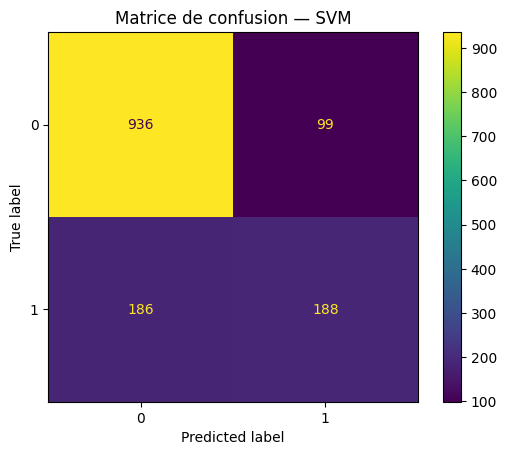

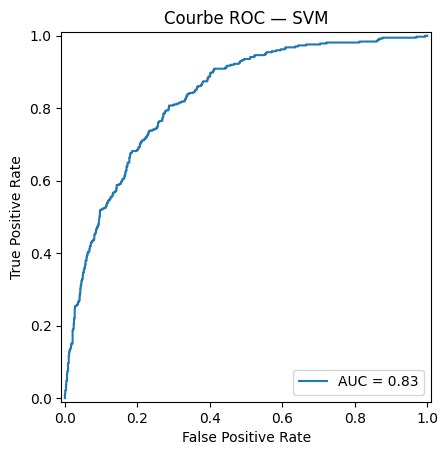

In [8]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

svm_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", SVC(probability=True, random_state=42))
])

svm_param_grid = {
    "clf__C": [0.1, 1, 10],
    "clf__kernel": ["rbf", "linear"],
    "clf__gamma": ["scale", "auto"]
}

svm_grid = GridSearchCV(
    svm_pipeline,
    svm_param_grid,
    scoring="roc_auc",
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    n_jobs=-1
)

svm_best, svm_auc = evaluate_best_model(
    "SVM",
    svm_grid,
    X_train, y_train,
    X_test, y_test
)

RANDOM FOREST (RF) CLASSIFIER

MODELE : Random Forest
Meilleurs paramètres : {'clf__max_depth': 10, 'clf__min_samples_split': 10, 'clf__n_estimators': 200}
Meilleur score CV (ROC-AUC) : 0.8450
ROC-AUC (test) : 0.8396


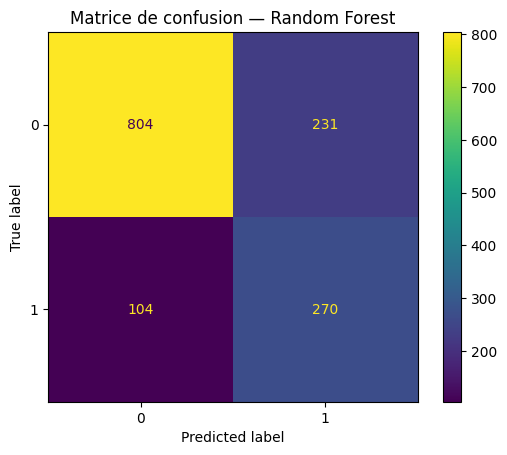

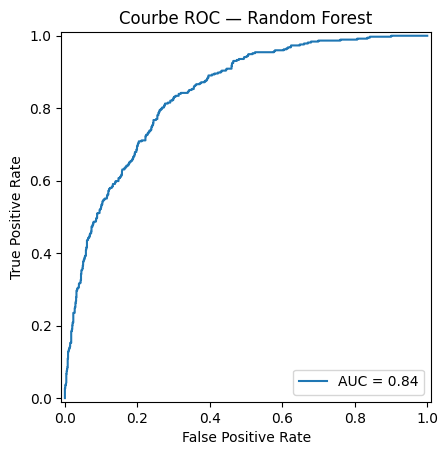

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

rf_param_grid = {
    "clf__n_estimators": [100, 200, 400],
    "clf__max_depth": [10, 20 , 50],
    "clf__min_samples_split": [2, 5 ,10]
}

rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    scoring="roc_auc",
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    n_jobs=-1
)

rf_best, rf_auc = evaluate_best_model(
    "Random Forest",
    rf_grid,
    X_train, y_train,
    X_test, y_test
)

MULTILAYER PERCEPTION (MLP) CLASSIFIER

MODELE : Réseau de neurones (MLP)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Meilleurs paramètres : {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (64,), 'clf__learning_rate_init': 0.001}
Meilleur score CV (ROC-AUC) : 0.8153
ROC-AUC (test) : 0.8158


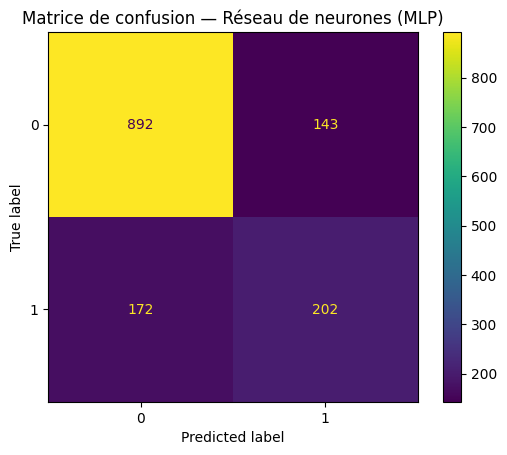

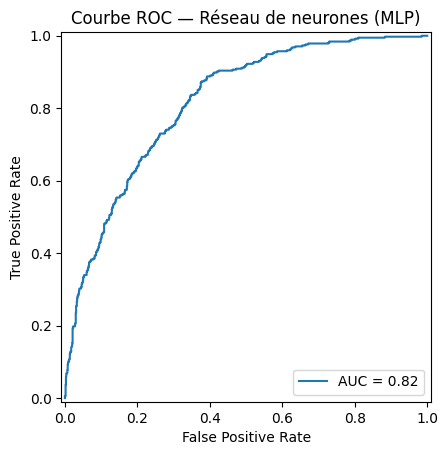

In [15]:
from sklearn.neural_network import MLPClassifier

mlp_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", MLPClassifier(
        max_iter=300,
        random_state=42
    ))
])

mlp_param_grid = {
    "clf__hidden_layer_sizes": [(64,), (64,32)],
    "clf__alpha": [0.0001, 0.001],
    "clf__learning_rate_init": [0.001, 0.01]
}

mlp_grid = GridSearchCV(
    mlp_pipeline,
    mlp_param_grid,
    scoring="roc_auc",
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    n_jobs=-1
)

mlp_best, mlp_auc = evaluate_best_model(
    "Réseau de neurones (MLP)",
    mlp_grid,
    X_train, y_train,
    X_test, y_test
)

EXTREME GRADIENT BOOST (XGBOOST) CLASSIFIER

MODELE : XGBoost
Meilleurs paramètres : {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 300, 'clf__subsample': 1.0}
Meilleur score CV (ROC-AUC) : 0.8466
ROC-AUC (test) : 0.8433


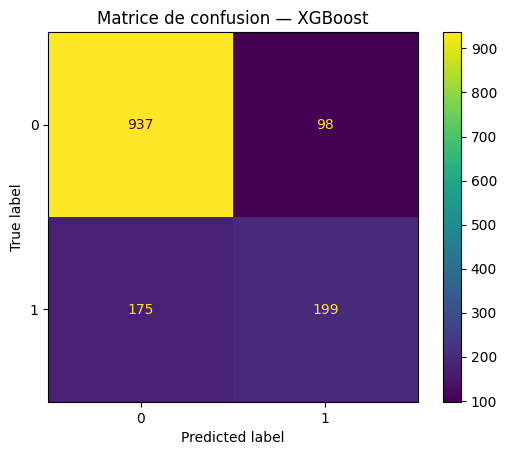

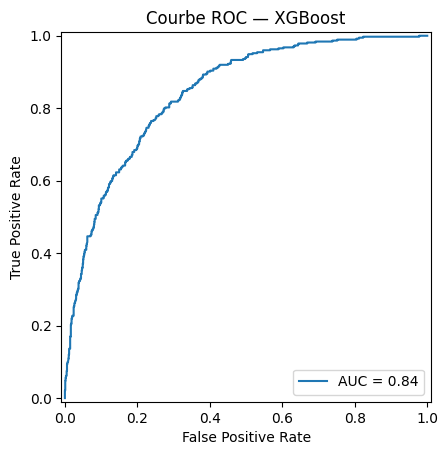

In [11]:
from xgboost import XGBClassifier

xgb_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ))
])

xgb_param_grid = {
    "clf__n_estimators": [300, 500],
    "clf__max_depth": [3, 5],
    "clf__learning_rate": [0.05, 0.1],
    "clf__subsample": [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    xgb_pipeline,
    xgb_param_grid,
    scoring="roc_auc",
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    n_jobs=-1
)

xgb_best, xgb_auc = evaluate_best_model(
    "XGBoost",
    xgb_grid,
    X_train, y_train,
    X_test, y_test
)

In [16]:
results = pd.DataFrame({
    "Modèle": ["SVM", "Random Forest", "MLP", "XGBoost"],
    "ROC-AUC (test)": [svm_auc, rf_auc, mlp_auc, xgb_auc]
}).sort_values("ROC-AUC (test)", ascending=False)

results

,Modèle,ROC-AUC (test)
3,XGBoost,0.843316
1,Random Forest,0.839629
0,SVM,0.830489
2,MLP,0.815815
